# The first step in this task is to generate the train and test dataset. There are two methods that I tried. The inputs I am provided are masses,initial positions,initial velocities and time at which position need to be predicted. One method is to use Euler numerical approach to determine the final coordinates. The basic idea is to assume that for small time intervals accleration and forces remain constant and then calculating the position after small time interval and doing this iteratively. Final position is accurate if we choose small dt as used in the code but increasing computation time.

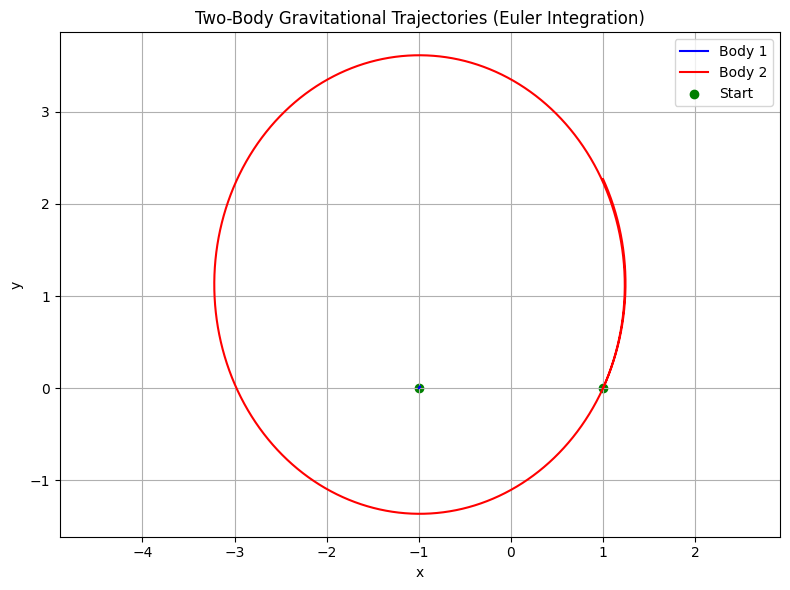

(np.float64(-0.9910007529330216),
 np.float64(0.017855701093249066),
 np.float64(1.0007529330179568),
 np.float64(2.2682989067512924))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# simulate_two_body_motion is the function used to predict position at time t given the inputs
def simulate_two_body_motion(
    m1, m2,
    x1, y1, x2, y2,
    v1x, v1y, v2x, v2y,
    t_final,
    G=1,         # I took G to be unity for computational efficiency
    dt=0.00001,  # This is the small time interval within which force and acclerations are assumed constant
    collision_threshold=1e-6    # This term describes that in reality bodies are not point masses and if they come within some distance then they will collide and simulation stops
):
    r1 = np.array([x1, y1], dtype=float)
    r2 = np.array([x2, y2], dtype=float)
    v1 = np.array([v1x, v1y], dtype=float)
    v2 = np.array([v2x, v2y], dtype=float)  # Describing the positions and velocities as vectors

    time = 0.0
    frozen = False

    # For plotting
    r1_list = [r1.copy()]
    r2_list = [r2.copy()]

    for _ in range(int(t_final / dt)):
        r12 = r2 - r1      # This is a vector from body 1 to body 2
        dist = np.linalg.norm(r12)

        if not frozen and dist < collision_threshold:     # This condition checks that if they are within collision threshold then they collide at their centre of mass and simulation stops
            com = (m1 * r1 + m2 * r2) / (m1 + m2)
            r1[:] = com
            r2[:] = com
            v1[:] = 0
            v2[:] = 0
            frozen = True
            break

        if not frozen:
            soft_dist = max(dist, 1e-3)           # soft_dist is used to make the force constant when they come within close proximity this is done so that force does not blow to infinity
            force_mag = G * m1 * m2 / soft_dist**2
            force_dir = r12 / soft_dist   # Unit vector along the direction of r12
            F = force_mag * force_dir

            v1 += F / m1 * dt
            v2 -= F / m2 * dt
            r1 += v1 * dt
            r2 += v2 * dt       # Updating the positions and velocities assuming constant force and velocities within time interval dt

        r1_list.append(r1.copy())
        r2_list.append(r2.copy())
        time += dt

    # Convert to numpy arrays for plotting
    r1_array = np.array(r1_list)
    r2_array = np.array(r2_list)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(r1_array[:, 0], r1_array[:, 1], label="Body 1", color="blue")
    plt.plot(r2_array[:, 0], r2_array[:, 1], label="Body 2", color="red")
    plt.scatter([r1_array[0, 0], r2_array[0, 0]], [r1_array[0, 1], r2_array[0, 1]], color='green', label='Start')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Two-Body Gravitational Trajectories (Euler Integration)")
    plt.legend()
    plt.axis("equal")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return r1[0], r1[1], r2[0], r2[1]

# Example usage
simulate_two_body_motion(
    m1=1000, m2=1.0,
    x1=-1.0, y1=0.0,
    x2=1, y2=0.0,
    v1x=0.0, v1y=0.0,
    v2x=10, v2y=22.36,
    t_final=0.9
)


# The second numerical approach that I tried is solve_ivp method using RK45. solve_ivp is a numerical ODE solver — it solves initial value problems (IVPs) for systems of ordinary differential equations. It is more accurate than euler approach but in this problem it could not increase postion accuracy to a considerable extent.


Final time: 0.9000
Body 1 final position: x = -0.9910014262379303, y = 0.0178567607934132
Body 2 final position: x = 1.0014262379309207, y = 2.2672392065867975


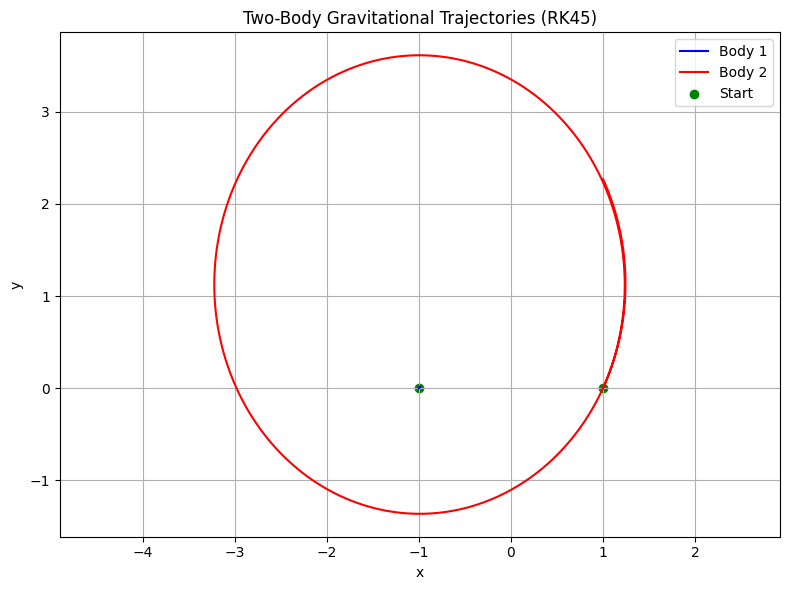

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def simulate_two_body_trajectory(
    m1, m2,
    x1, y1, x2, y2,
    v1x, v1y, v2x, v2y,
    t_final,
    G=1.0,
    collision_threshold=1e-3
):
    def deriv(t, y):   # function to calculate derivative at time t for all parameters of y which is an array y=[x1, y1, x2, y2, v1x, v1y, v2x, v2y]
        r1 = y[0:2]
        r2 = y[2:4]
        v1 = y[4:6]
        v2 = y[6:8]

        r12 = r2 - r1
        dist = np.linalg.norm(r12)
        soft_dist = max(dist, 1e-3)

        force_mag = G * m1 * m2 / soft_dist**2
        force_dir = r12 / soft_dist
        F = force_mag * force_dir

        a1 = F / m1
        a2 = -F / m2

        return np.concatenate([v1, v2, a1, a2])

    def collision_event(t, y):
        r1 = y[0:2]
        r2 = y[2:4]
        return np.linalg.norm(r2 - r1) - collision_threshold

    collision_event.terminal = True # If the function collision_event triggers then then the ODE solver stops integration immediately
    collision_event.direction = -1  # It means that the event function will trigger if the event value crosses zero from positive to negative

    y0 = np.array([x1, y1, x2, y2, v1x, v1y, v2x, v2y], dtype=float)

    sol = solve_ivp(
        deriv,
        [0, t_final],
        y0,
        method='RK45',     # Using Runge-Kutta method of order 5(4)
        events=collision_event,
        rtol=1e-9,
        atol=1e-9,
        dense_output=True
    )

    final_time = sol.t_events[0][0] if sol.status == 1 else t_final # This line detects time at which first collision occurs in case collision event took place
    t_vals = np.linspace(0, final_time, 1000)  # Creating a numpy array with 1000 equally spaced time points from 0 to final_time
    traj = sol.sol(t_vals)                     # traj is a 2D numpy array of shape (8,len(t_vals)) and it store the values of each variable at any time t in t_vals

    # Extract final positions
    x1_final, y1_final = traj[0][-1], traj[1][-1]
    x2_final, y2_final = traj[2][-1], traj[3][-1]

    print(f"\nFinal time: {final_time:.4f}")
    print(f"Body 1 final position: x = {x1_final:.16f}, y = {y1_final:.16f}")
    print(f"Body 2 final position: x = {x2_final:.16f}, y = {y2_final:.16f}")

    return t_vals, traj

# Parameters
m1 = 1000
m2 = 1.0
x1, y1 = -1.0, 0.0
x2, y2 = 1.0, 0.0
v1x, v1y = 0.0, 0.0
v2x, v2y = 10.0, 22.36
t_final = 0.9

# Simulate and get trajectories
t_vals, traj = simulate_two_body_trajectory(m1, m2, x1, y1, x2, y2, v1x, v1y, v2x, v2y, t_final)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(traj[0], traj[1], label='Body 1', color='blue')
plt.plot(traj[2], traj[3], label='Body 2', color='red')
plt.scatter([traj[0][0], traj[2][0]], [traj[1][0], traj[3][0]], color='green', label='Start')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Two-Body Gravitational Trajectories (RK45)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


# The next step is to make our own training and testing csv files. I have created training dataset with 100000 samples and testing dataset with 25000 samples. Since we need to train a neural network on time domain so for each set of values I considered various t(time) values.

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import random

def simulate_two_body_trajectory(
    m1, m2,
    x1, y1, x2, y2,
    v1x, v1y, v2x, v2y,
    t_final,
    G=1.0,
    collision_threshold=1e-3,
    num_points=50
):
    def deriv(t, y):
        r1 = y[0:2]
        r2 = y[2:4]
        v1 = y[4:6]
        v2 = y[6:8]
        r12 = r2 - r1
        dist = np.linalg.norm(r12)
        soft_dist = max(dist, 1e-3)
        force_mag = G * m1 * m2 / soft_dist**2
        force_dir = r12 / soft_dist
        F = force_mag * force_dir
        a1 = F / m1
        a2 = -F / m2
        return np.concatenate([v1, v2, a1, a2])

    def collision_event(t, y):
        r1 = y[0:2]
        r2 = y[2:4]
        return np.linalg.norm(r2 - r1) - collision_threshold
    collision_event.terminal = True
    collision_event.direction = -1

    y0 = np.array([x1, y1, x2, y2, v1x, v1y, v2x, v2y], dtype=float)

    sol = solve_ivp(
        deriv, [0, t_final], y0,
        method='RK45',
        events=collision_event,
        rtol=1e-8,
        atol=1e-8,
        dense_output=True
    )

    if sol.status == 1:
        # Collision happened at t_collision
        t_collision = sol.t_events[0][0]
        t_vals = np.linspace(0, t_final, num_points)
        traj = np.zeros((8, num_points))

        # Calculate pre-collision points
        mask = t_vals <= t_collision
        t_pre = t_vals[mask]
        traj[:, mask] = sol.sol(t_pre)

        # Calculate post-collision points
        r1c = sol.sol(t_collision)[0:2]
        r2c = sol.sol(t_collision)[2:4]
        com = (m1 * r1c + m2 * r2c) / (m1 + m2)
        for i in range(np.sum(~mask)):
            traj[0:2, ~mask][0:2, i] = com
            traj[2:4, ~mask][0:2, i] = com
            traj[4:, ~mask][:, i] = 0

    else:
        t_vals = np.linspace(0, t_final, num_points)
        traj = sol.sol(t_vals)

    return t_vals, traj

# Data generation
def generate_data_csv(filename, n_samples):
    data = []
    for _ in range(n_samples):
        m1 = random.uniform(0.5, 5.0)
        m2 = random.uniform(0.5, 5.0)
        x1, y1 = random.uniform(-2, 2), random.uniform(-2, 2)
        x2, y2 = random.uniform(-2, 2), random.uniform(-2, 2)
        v1x, v1y = random.uniform(-2, 2), random.uniform(-2, 2)
        v2x, v2y = random.uniform(-2, 2), random.uniform(-2, 2)
        t_final = random.choice([2, 3, 4, 5, 6, 7, 8,])

        t_vals, traj = simulate_two_body_trajectory(
            m1, m2, x1, y1, x2, y2, v1x, v1y, v2x, v2y, t_final
        )

        for i in range(len(t_vals)):
            data.append([
                m1, m2, x1, y1, x2, y2, v1x, v1y, v2x, v2y,
                t_vals[i],
                traj[0, i], traj[1, i], traj[2, i], traj[3, i]
            ])

    df = pd.DataFrame(data, columns=[
        'm1', 'm2', 'x1', 'y1', 'x2', 'y2', 'v1x', 'v1y', 'v2x', 'v2y', 't',
        'X1', 'Y1', 'X2', 'Y2'
    ])
    df.to_csv(filename, index=False)
    print(f"Saved {len(df)} samples to {filename}")

# Generate files
generate_data_csv("trajectory_predictor_train.csv", n_samples=2000)
generate_data_csv("trajectory_predictor_test.csv", n_samples=500)


Saved 100000 samples to trajectory_predictor_train.csv
Saved 25000 samples to trajectory_predictor_test.csv


In [ ]:
from google.colab import files
files.download('trajectory_predictor_train.csv')
files.download('trajectory_predictor_test.csv')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving trajectory_predictor_train.csv to trajectory_predictor_train.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving trajectory_predictor_test.csv to trajectory_predictor_test.csv


In [ ]:
import pandas as pd
df_train=pd.read_csv('trajectory_predictor_train.csv')
df_test=pd.read_csv('trajectory_predictor_test.csv')
print(df_train.shape)
print(df_test.shape)

(100000, 15)
(25000, 15)


# Now we will train a simple neural network on the train dataset and test it on the test dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load training data
df_train = pd.read_csv("trajectory_predictor_train.csv")

# Separate input features and output targets
X_train = df_train[["m1", "m2", "x1", "y1", "x2", "y2", "v1x", "v1y", "v2x", "v2y", "t"]].values
y_train = df_train[["X1", "Y1", "X2", "Y2"]].values

# Normalize input and output
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(11,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation= 'relu'),
    Dense(16, activation= 'relu'),
    Dense(8, activation= 'relu'),
    Dense(4)  # Output layer: X1, Y1, X2, Y2
])

# Compile the model
model.compile(optimizer='adam', loss='huber', metrics=['mae'])

# Train the model
model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=20, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.1170 - mae: 0.3239
Epoch 2/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0287 - mae: 0.1640
Epoch 3/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0178 - mae: 0.1348
Epoch 4/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.0135 - mae: 0.1197
Epoch 5/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0114 - mae: 0.1102
Epoch 6/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0098 - mae: 0.1030
Epoch 7/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0090 - mae: 0.0987
Epoch 8/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0082 - mae: 0.0947
Epoch 9/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0076 - mae: 0.0911
Epoch 10/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0070 - mae: 0.0874
Epoch 11/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0069 - mae: 0.0863
Epoch 12/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0067 - m

In [ ]:
model.save("trajectory_predictor_NN_model.h5")
np.save("scaler_X_mean.npy", scaler_X.mean_)
np.save("scaler_X_scale.npy", scaler_X.scale_)
np.save("scaler_y_mean.npy", scaler_y.mean_)
np.save("scaler_y_scale.npy", scaler_y.scale_)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

# Load test dataset
test_df = pd.read_csv('trajectory_predictor_test.csv')

# Extract input features (same columns as training inputs)
input_cols = ['m1', 'm2', 'x1', 'y1', 'x2', 'y2', 'v1x', 'v1y', 'v2x', 'v2y', 't']
X_test = test_df[input_cols].values
X_test_scaled=scaler_X.transform(X_test)

# Extract ground truth outputs
output_cols = ['X1', 'Y1', 'X2', 'Y2']
y_true = test_df[output_cols].values
y_true_scaled=scaler_y.transform(y_true)

# Load the trained model (update the path if needed)
model = tf.keras.models.load_model('trajectory_predictor_NN_model.h5', compile=False)


# Make predictions
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculate Mean Absolute Error for each coordinate
mae_per_coordinate = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
print(f"MAE per coordinate: X1={mae_per_coordinate[0]:.5f}, Y1={mae_per_coordinate[1]:.5f}, X2={mae_per_coordinate[2]:.5f}, Y2={mae_per_coordinate[3]:.5f}")

# Calculate overall MAE (average over all coordinates)
overall_mae = mean_absolute_error(y_true, y_pred)
print(f"Overall MAE: {overall_mae:.5f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
MAE per coordinate: X1=0.66347, Y1=0.68565, X2=0.62831, Y2=0.68295
Overall MAE: 0.66510


# As we trained the model and test it on the test data we get an MAE score of 0.66 which is not good enough. So now we will try another approach which is Physics Informed Neural network called PINN in short. The main difference between PINN and NN is that NN is trained on the dataset only but PINN is trained on dataset as well as the differential equation governing the trajectories of the particles. Thereby it can decrease the MAE score considerably

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models

# Load Data
df = pd.read_csv("trajectory_predictor_train.csv")
X = df.drop(columns=["x1", "y1", "x2", "y2"]).values
y = df[["X1", "Y1", "X2", "Y2"]].values

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val)

scale_X = tf.constant(scaler_X.scale_, dtype=tf.float32)
scale_y = tf.constant(scaler_y.scale_, dtype=tf.float32)

batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_scaled)).shuffle(1000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val_scaled)).batch(batch_size)

model = models.Sequential([
    layers.Input(shape=(11,)),
    layers.Dense(128, activation='tanh'),
    layers.Dense(128, activation='tanh'),
    layers.Dense(128, activation='tanh'),
    layers.Dense(64, activation='tanh'),
    layers.Dense(64, activation='tanh'),
    layers.Dense(64, activation='tanh'),
    layers.Dense(4)
])

@tf.function
def physics_loss_fn(X_batch):
    X_batch = tf.cast(X_batch, tf.float32)
    # Unscale time t
    t = tf.expand_dims(X_batch[:, 10] * scale_X[10], axis=1)  # shape (batch_size,1)

    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(t)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(t)
            y_pred = model(X_batch, training=True)  # shape (batch, 4)
            x1, y1, x2, y2 = tf.split(y_pred, 4, axis=1)

        dx1_dt = tape1.gradient(x1, t)
        dy1_dt = tape1.gradient(y1, t)
        dx2_dt = tape1.gradient(x2, t)
        dy2_dt = tape1.gradient(y2, t)

        # Replace None with zeros to avoid errors
        dx1_dt = tf.zeros_like(x1) if dx1_dt is None else dx1_dt
        dy1_dt = tf.zeros_like(y1) if dy1_dt is None else dy1_dt
        dx2_dt = tf.zeros_like(x2) if dx2_dt is None else dx2_dt
        dy2_dt = tf.zeros_like(y2) if dy2_dt is None else dy2_dt

    d2x1_dt2 = tape2.gradient(dx1_dt, t)
    d2y1_dt2 = tape2.gradient(dy1_dt, t)
    d2x2_dt2 = tape2.gradient(dx2_dt, t)
    d2y2_dt2 = tape2.gradient(dy2_dt, t)

    # Replace None second derivatives with zeros
    d2x1_dt2 = tf.zeros_like(dx1_dt) if d2x1_dt2 is None else d2x1_dt2
    d2y1_dt2 = tf.zeros_like(dy1_dt) if d2y1_dt2 is None else d2y1_dt2
    d2x2_dt2 = tf.zeros_like(dx2_dt) if d2x2_dt2 is None else d2x2_dt2
    d2y2_dt2 = tf.zeros_like(dy2_dt) if d2y2_dt2 is None else d2y2_dt2

    del tape1
    del tape2

    # Constants
    G = 1.0
    # Masses from input features (assuming first two columns are m1, m2)
    m1 = tf.expand_dims(X_batch[:, 0], axis=1)
    m2 = tf.expand_dims(X_batch[:, 1], axis=1)

    # Positions scaled back to original scale
    x1_phys = x1 * scale_y[0]
    y1_phys = y1 * scale_y[1]
    x2_phys = x2 * scale_y[2]
    y2_phys = y2 * scale_y[3]

    # Compute distances and avoid division by zero with epsilon
    dx = x2_phys - x1_phys
    dy = y2_phys - y1_phys
    dist_sq = dx**2 + dy**2 + 1e-6
    dist = tf.sqrt(dist_sq)

    # Gravitational acceleration components
    a1x = G * m2 * dx / (dist_sq * dist)
    a1y = G * m2 * dy / (dist_sq * dist)
    a2x = -G * m1 * dx / (dist_sq * dist)
    a2y = -G * m1 * dy / (dist_sq * dist)

    # Acceleration predicted by network (scaled)
    d2x1_dt2_scaled = d2x1_dt2 * scale_y[0] / (scale_X[10] ** 2)
    d2y1_dt2_scaled = d2y1_dt2 * scale_y[1] / (scale_X[10] ** 2)
    d2x2_dt2_scaled = d2x2_dt2 * scale_y[2] / (scale_X[10] ** 2)
    d2y2_dt2_scaled = d2y2_dt2 * scale_y[3] / (scale_X[10] ** 2)

    # Physics residuals (difference between predicted accelerations and Newton's law)
    loss_1x = tf.square(d2x1_dt2_scaled - a1x)
    loss_1y = tf.square(d2y1_dt2_scaled - a1y)
    loss_2x = tf.square(d2x2_dt2_scaled - a2x)
    loss_2y = tf.square(d2y2_dt2_scaled - a2y)

    physics_loss = tf.reduce_mean(loss_1x + loss_1y + loss_2x + loss_2y)

    return physics_loss

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

@tf.function
def train_step(X_batch, y_batch, lambda_phys):
    y_batch = tf.cast(y_batch, tf.float32)
    with tf.GradientTape() as tape:
        y_pred_scaled = model(X_batch, training=True)
        data_loss = tf.reduce_mean(tf.square(y_batch - y_pred_scaled))
        phys_loss = physics_loss_fn(X_batch)
        total_loss = data_loss + lambda_phys * phys_loss

    grads = tape.gradient(total_loss, model.trainable_variables)
    grads, _ = tf.clip_by_global_norm(grads, 5.0)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    grad_norm = tf.linalg.global_norm(grads)
    return total_loss, data_loss, phys_loss, grad_norm

def evaluate_model(model, X_val_scaled, y_val):
    y_pred_scaled = model.predict(X_val_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    return np.mean(np.abs(y_val - y_pred))

epochs = 50
lambda_phys_start = 1e-6
lambda_phys_end = 1e-3

for epoch in range(epochs):
    lambda_phys = lambda_phys_start + (lambda_phys_end - lambda_phys_start) * (epoch / (epochs - 1))

    epoch_loss, epoch_data_loss, epoch_phys_loss, epoch_grad_norm = 0.0, 0.0, 0.0, 0.0
    batches = 0
    for X_batch, y_batch in train_dataset:
        total_loss, data_loss, phys_loss, grad_norm = train_step(X_batch, y_batch, lambda_phys)
        epoch_loss += total_loss.numpy()
        epoch_data_loss += data_loss.numpy()
        epoch_phys_loss += phys_loss.numpy()
        epoch_grad_norm += grad_norm.numpy()
        batches += 1

    val_mae = evaluate_model(model, X_val_scaled, y_val)
    print(f"Epoch {epoch+1}/{epochs} - Total Loss: {epoch_loss/batches:.4f}, Data: {epoch_data_loss/batches:.4f}, Physics: {epoch_phys_loss/batches:.4f}, Grad Norm: {epoch_grad_norm/batches:.4f}, Lambda_phys: {lambda_phys:.6f}, Val MAE: {val_mae:.4f}")


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 1/50 - Total Loss: 0.8511, Data: 0.5543, Physics: 296742.3438, Grad Norm: 1.4669, Lambda_phys: 0.000001, Val MAE: 0.5478
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 2/50 - Total Loss: 134.6419, Data: 0.4557, Physics: 6273963.0000, Grad Norm: 2.1938, Lambda_phys: 0.000021, Val MAE: 0.5689
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 3/50 - Total Loss: 80.1639, Data: 0.3983, Physics: 1909375.6250, Grad Norm: 2.0717, Lambda_phys: 0.000042, Val MAE: 0.5471
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 4/50 - Total Loss: 1.9817, Data: 0.3897, Physics: 25609.9004, Grad Norm: 2.2902, Lambda_phys: 0.000062, Val MAE: 0.5386
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 5/50 - Total Loss: 20.4197, Data: 0.3568, Physics: 243035.5469, Grad Norm: 2.0807, Lambda_phys: 0.000083, Val MAE: 0.5232
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 6/50 - Total Loss: 19.8787, Data: 0.3576, Physics: 189637.9844, Grad Norm: 2.2220, Lambda_phys: 0.000103, Va

In [ ]:
model.save("trajectory_predictor_PINN_model.keras")
print("Model saved successfully.")


Model saved successfully.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Load saved model
model = tf.keras.models.load_model("trajectory_predictor_PINN_model.keras")

# Load test data (can be train or separate test CSV)
df_test = pd.read_csv("trajectory_predictor_train.csv")  # Or your test CSV
X_test = df_test.drop(columns=["x1", "y1", "x2", "y2"]).values
y_test = df_test[["x1", "y1", "x2", "y2"]].values

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit scalers on training data only, assuming train CSV is available
df_train = pd.read_csv("trajectory_predictor_train.csv")
X_train = df_train.drop(columns=["x1", "y1", "x2", "y2"]).values
y_train = df_train[["x1", "y1", "x2", "y2"]].values

scaler_X.fit(X_train)
scaler_y.fit(y_train)

# Scale test data
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

# Predict scaled outputs
y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform predictions
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculate MAE
mae = np.mean(np.abs(y_test - y_pred))
print(f"Test MAE: {mae:.4f}")


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Test MAE: 0.3511


# Finally using PINN got an MAE score of 0.35 on test dataset.

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load training data
train_df = pd.read_csv("trajectory_predictor_train.csv")
X_train = train_df[['m1', 'm2', 'x1', 'y1', 'x2', 'y2', 'v1x', 'v1y', 'v2x', 'v2y', 't']].values
Y_train = df[["X1", "Y1", "X2", "Y2"]].values

# Initialize StandardScaler and fit it to the training data
scaler_X = StandardScaler()
scaler_X.fit(X_train)

# Save the mean and scale (standard deviation) of the scaler for later use
np.save('scaler_X_mean.npy', scaler_X.mean_)
np.save('scaler_X_scale.npy', scaler_X.scale_)

scaler_y.fit(Y_train)  # If you scaled outputs
np.save('scaler_y_mean.npy', scaler_y.mean_)
np.save('scaler_y_scale.npy', scaler_y.scale_)


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load trained model
model = tf.keras.models.load_model("trajectory_predictor_PINN_model.keras")

# Load the saved scaler parameters
scaler_X_mean = np.load('scaler_X_mean.npy')
scaler_X_scale = np.load('scaler_X_scale.npy')

# Initialize the scaler with the saved parameters
scaler_X = StandardScaler()
scaler_X.mean_ = scaler_X_mean
scaler_X.scale_ = scaler_X_scale

# Take user input for prediction
m1 = float(input("Enter mass of body 1: "))
m2 = float(input("Enter mass of body 2: "))
x1 = float(input("Enter x1: "))
y1 = float(input("Enter y1: "))
x2 = float(input("Enter x2: "))
y2 = float(input("Enter y2: "))
v1x = float(input("Enter v1x: "))
v1y = float(input("Enter v1y: "))
v2x = float(input("Enter v2x: "))
v2y = float(input("Enter v2y: "))
t_final = float(input("Enter final time t: "))

# Create input array for scaling
X_input = np.array([[m1, m2, x1, y1, x2, y2, v1x, v1y, v2x, v2y, t_final]])

# Scale the user input using the loaded scaler
X_input_scaled = scaler_X.transform(X_input)

# Make prediction using the trained PINN model
y_pred_scaled = model.predict(X_input_scaled)


scaler_y_mean = np.load('scaler_y_mean.npy')
scaler_y_scale = np.load('scaler_y_scale.npy')
scaler_y = StandardScaler()
scaler_y.mean_ = scaler_y_mean
scaler_y.scale_ = scaler_y_scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)

print(f"\nFinal positions at t={t_final} using PINN:")
print(f"Body 1: x = {y_pred[0, 0]:.6f}, y = {y_pred[0, 1]:.6f}")
print(f"Body 2: x = {y_pred[0, 2]:.6f}, y = {y_pred[0, 3]:.6f}")


Enter mass of body 1: 2
Enter mass of body 2: 2
Enter x1: -1
Enter y1: 0
Enter x2: 1
Enter y2: 0
Enter v1x: 0
Enter v1y: 1.5
Enter v2x: 0
Enter v2y: -1.5
Enter final time t: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step

Final positions at t=2.0 using PINN:
Body 1: x = 4.160061, y = -0.951318
Body 2: x = -3.417928, y = -1.070217
